In [2]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from map_plan import Map

In [5]:
"""
Create a default map using `load_map`
"""
map = Map()
print(map.map.shape)

torch.Size([20, 20, 3])


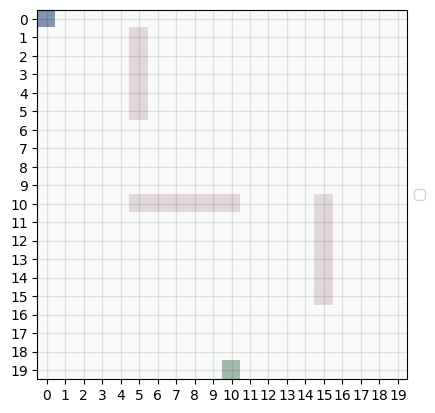

In [6]:
"""
Visualize the map tensor using `imshow`:
    the first plane has obstacles (marked with 1)
    the second plane has the goal position (marked with 1)
    the third plane has the current position (marked with 1)

The plane is along the final axis.

Put all of them together to visualize the map tensor using a bright color scheme. 
"""
plt.imshow(map.return_obstacle_map(), cmap='Reds', alpha=0.9)
plt.imshow(map.return_goal_position(), cmap='Greens', alpha=0.7)
plt.imshow(map.return_current_position(), cmap='Blues', alpha=0.5)

# put the legend on the right side
plt.legend(['obstacles', 'goal', 'current position'], loc='center left', bbox_to_anchor=(1, 0.5))

# put the axes on both sides and use integer ticks.
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

# put a grid with a faint color
plt.grid(True, which='both', color='black', linestyle='-', linewidth=1, alpha=0.1)


plt.show()

tensor([[0],
        [0]])


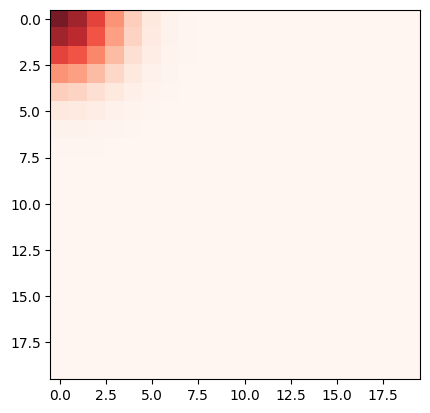

In [7]:
"""
extract the current position from `map` (the third plane).
compute the soft position mask using `get_position_mask` and visualize it using `imshow`.
"""

# the current position is marked as 1 in the third plane. extract the (x,y) coordinate.
current_position = np.argwhere(map.return_current_position() == 1)
print(current_position)

# compute the soft position mask using `get_position_mask`
position_mask = map.get_position_mask(current_position[0], current_position[1], beta=.1)

# visualize the soft position mask using `imshow`
plt.imshow(position_mask, cmap='Reds', alpha=0.9)
plt.show()


tensor([[19],
        [10]])


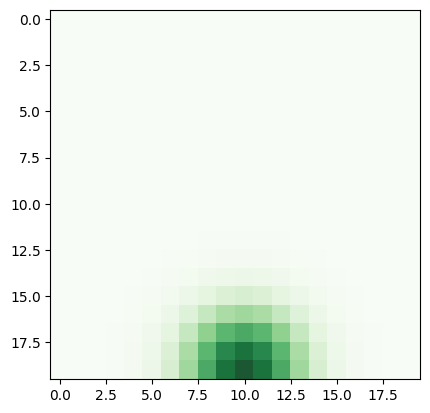

In [8]:
"""
extract the goal position from `map` (the second plane).
compute the soft position mask using `get_position_mask` and visualize it using `imshow`.
"""

# the goal position is marked as 1 in the second plane. extract the (x,y) coordinate.
goal_position = np.argwhere(map.return_goal_position() == 1)
print(goal_position)

# compute the soft position mask using `get_position_mask`
goal_mask = map.get_position_mask(goal_position[0], goal_position[1], beta=.1)

# visualize the soft position mask using `imshow`
plt.imshow(goal_mask, cmap='Greens', alpha=0.9)
plt.show()

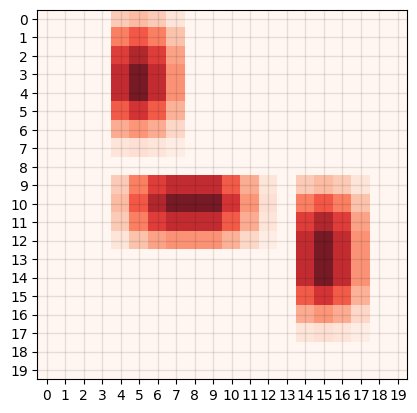

In [9]:
smoothed_obstacle_map = map.smooth_map(plane=0, sigma=1.5, size=4)
plt.imshow(smoothed_obstacle_map, cmap='Reds', alpha=0.9)
# put the axes on both sides and use integer ticks.
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

# put a grid with a faint color
plt.grid(True, which='both', color='black', linestyle='-', linewidth=1, alpha=0.1)
plt.show()


tensor(0.3492, grad_fn=<SumBackward0>)


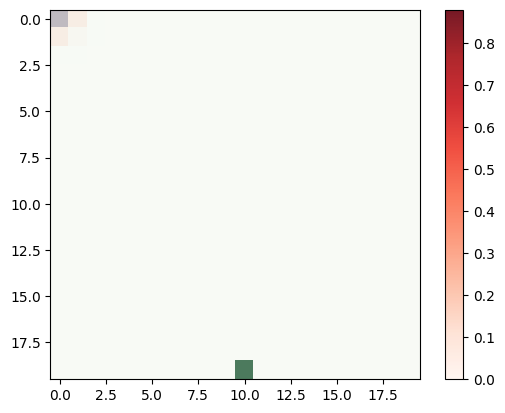

In [10]:
"""
compute the distance between the current `position_mask` and goal positions `goal_mask` 
using the soft masks, compute its gradient and visualize it using `imshow`.
"""
distance, grad = map.distance_to_goal(compute_grad=True, obstacle_strength=1., beta=1.)
print(distance)

# visualize the gradient using `imshow`
plt.imshow(grad/grad.norm(), cmap='Reds', alpha=0.9)
# show the color bar for the gradient
plt.colorbar()

# visualize the current position using `imshow`
plt.imshow(map.return_current_position(), cmap='Blues', alpha=0.5)
# visualize the goal position using `imshow`
plt.imshow(map.return_goal_position(), cmap='Greens', alpha=0.7)

plt.show()

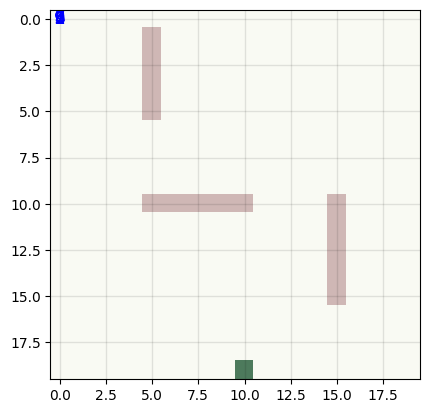

In [27]:
# reset the map
map = Map()

# the number of steps
n_steps = 10

# the number of inner steps
n_inner_steps = 50

# set the step size
step_size = 1.

# decreate ratio
decrease_ratio = 0.9

# tolerance
tol_max = 0

# trust region
delta_max = 3

plt.figure()

# place the obstacles
plt.imshow(map.return_obstacle_map(), cmap='Reds', alpha=0.9)

# get the goal coordinate
goal_x, goal_y = map.return_goal_position(as_coordinate=True)

for i in range(n_steps):
    # visualize the new position mask using `imshow`
    current_pos_x, current_pos_y = map.return_current_position(as_coordinate=True)

    # put `i` as the marker at the current position (current_pos_x, current_pos_y)
    plt.text(current_pos_x, current_pos_y, str(i), color='blue', fontsize=12, ha='center', va='center')

    # compute the new position mask
    new_position_mask = map.get_position_mask(current_pos_x, current_pos_y, beta=0.01)    

    step_size = decrease_ratio * step_size

    for j in range(n_inner_steps):
        # compute the gradient and distance
        new_position_mask = new_position_mask.clone().detach()
        new_position_mask.grad = None
        distance, grad = map.distance_to_goal(current_position_mask=new_position_mask,
                                              compute_grad=True, 
                                              obstacle_strength=1., beta=0.01,
                                              sigma=2., size=6)

        # take the gradient step
        new_position_mask = new_position_mask - step_size * grad / grad.norm()

    # find the argmax coordinate from the new position mask
    new_position = np.unravel_index(torch.argmax(new_position_mask).item(), new_position_mask.shape)
    # compute delta position
    delta_position = torch.tensor([new_position[0] - current_pos_x, new_position[1] - current_pos_y])
    # delta_position can be at most delta_max
    delta_position = delta_position.clip(-delta_max, delta_max)

    for ti in range(tol_max):
        # get the next position considering the map boundaries and obstacles
        map.move_position(delta_position[0], delta_position[1], hypothetical=False)
        # get the new position coordinate
        new_pos_x, new_pos_y = map.return_current_position(as_coordinate=True)
        # check if the new position is the same as the old position
        if current_pos_x == new_pos_x and current_pos_y == new_pos_y:
            # add noise to the delta position
            delta_position = np.random.randint(-1, 2), np.random.randint(-1, 2)
            continue

# visualize the goal position using `imshow`
plt.imshow(map.return_goal_position(), cmap='Greens', alpha=0.7)

plt.grid(True, which='both', color='black', linestyle='-', linewidth=1, alpha=0.1)
plt.show()

In [13]:
delta_position

(tensor([0]), tensor([0]))

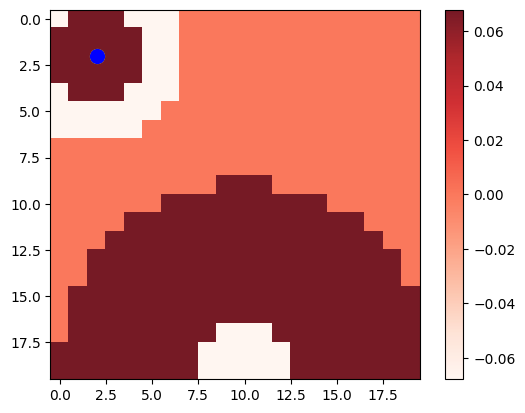

In [16]:
# visualize the gradient `grad` using `imshow`
plt.imshow(grad/grad.norm(), cmap='Reds', alpha=0.9)
# show the color bar for the gradient
plt.colorbar()

# visualize the final position using `scatter`
plt.scatter(current_pos_x, current_pos_y, color='yellow', s=100)
plt.scatter(new_position[1], new_position[0], color='blue', s=100)

plt.show()

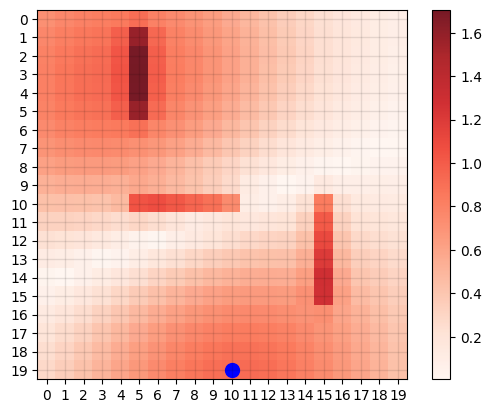

In [34]:
current_position_mask = map.get_position_mask(torch.where(map.map[:, :, 2] == 1)[0], 
                                                torch.where(map.map[:, :, 2] == 1)[1],
                                                beta=0.01)

smoothed_goal_map = map.get_position_mask(torch.where(map.map[:, :, 1] == 1)[0], 
                                            torch.where(map.map[:, :, 1] == 1)[1],
                                            beta=0.01)
distance = torch.abs(current_position_mask - smoothed_goal_map)
smoothed_obstacle_map = map.smooth_map(plane=0, sigma=0.5, size=10)
distance = distance + 1. * smoothed_obstacle_map


plt.imshow(distance, cmap='Reds', alpha=0.9)
# show the color bar for the gradient
plt.colorbar()

# visualize the final position using `scatter`
plt.scatter(new_position[1], new_position[0], color='blue', s=100)

# put the axes on both sides and use integer ticks.
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

# put a grid with a faint color
plt.grid(True, which='both', color='black', linestyle='-', linewidth=1, alpha=0.1)


plt.show()

In [22]:
np.sign(21)

1